 # <span style='background:purple'> <span style='color:White'> DECOMON for Industrial Challenges #1 </span></span>

<span style='color:purple'>_**Overestimation with formal guarantee for Braking Distance Estimation**_</span>

<p align="center">
  <img src="data/decomon.jpg" alt="Decomon!" width="100">
</p>



- &#x1F4DA; <a href="https://airbus.github.io/decomon"> <span style='color:purple'>Documentation</span> </a>
- <a href="https://github.com/airbus/decomon"> <span style='color:purple'>Github</span> </a>




_Author: [<span style='color:purple'>Melanie DUCOFFE</span>](https://fr.linkedin.com/in/m%C3%A9lanie-ducoffe-bbb53165)_


## Robustness for Regression tasks

In recent years, we have seen the emergence of safety-related properties for regression tasks in many industries. For example, numerical models have been developed to approximate the physical phenomena inherent in their systems. Since these models are based on physical equations, the relevance of which is affirmed by scientific experts, their qualifications are carried out without any problems.
 However, as their computational costs and execution time prevent us from embedding them, the use of these numerical models in the aeronautical domain remains mainly limited to the development and design phase of the aircraft. Thanks to the current success of deep neural networks, previous works have already studied neural network-based surrogates for the approximation of numerical models. Nevertheless, these surrogates have additional safety properties that need to be demonstrated to certification authorities. In this blog post, we will examine a specification that arises for a neural network used for take-off distance estimation which is the over-estimation of the simulation model. We will explore how to address them with _**decomon**_.
 
Embedding simulation models developed during the design of a platform opens a lot of potential 
new functionalities but requires additional certification. 
Usually, these models require too much computing power, take too much time to run 
so we need to build an approximation of these models that can be compatible with operational constraints,
hardware constraints, and real-time constraints. 
Also, we need to prove that the decisions made by the system using the surrogate model 
instead of the reference one will be **safe**. **The confidence in its safety has to be demonstrated 
to certification authorities**. 


- When running this notebook on Colab, we need to install *decomon* if on Colab. 
- If you run this notebook locally, do it inside the environment in which you [<span style='color:purple'>installed *decomon*</span>](https://airbus.github.io/decomon/main/install.html).

In [1]:
# On Colab: install the library
on_colab = "google.colab" in str(get_ipython())
if on_colab:
    import sys  # noqa: avoid having this import removed by pycln

    # install dev version for dev doc, or release version for release doc
    !{sys.executable} -m pip install -U pip
    !{sys.executable} -m pip install git+https://github.com/airbus/decomon@main#egg=decomon

## Landing Distance Estimation

In many cases, **safety can be ensured by systematically over estimating** the reference model. An intuitive example
is a surrogate that would predict the landing distance of an aircraft. Under-estimating the reference  distance  could  lead  to  an  avoidable  overrun. On  the contrary, over-estimating the reference distance may lead to unnecessary turn-around maneuvers when the landing was indeed safely possible.

**Based on this reasonning we can define safety as the following requirement: the neural network will over-estimate the reference model on any point**

<p align="center">
  <img src="./usecase/img/safe_surrogate.png" alt="SafeOverestimation!" width="400">
</p>

In this notebook, we will demonstrate how to _**train and assert with that a neural network is a safe surrogate**_.

### UseCase Description

The [Cessna 172 Skyhawk](https://en.wikipedia.org/wiki/Cessna_172) is an American four-seat, single-engine, high wing, fixed-wing aircraft made by the Cessna Aircraft Company. Measured by its longevity and popularity, the Cessna 172 is the most successful aircraft in history. Cessna delivered the first production model in 1956, and as of 2015, the company and its partners had built more than 44,000 units.The aircraft remains in production today.

<p align="center">
  <img src="usecase/img/cesna_c_172.jpeg" alt="SafeOverestimation!" width="400">
</p>


## Hands on ! Getting the data and training a braking distance estimator

We will assess the over-estimation guanratees we can obtain for landing estimation on a toy usecase (considering only  pressure altitude and temperature).
You can also build your own simulator using free online calculator for CESSNA C172 (source Flight Performance App)

### Imports

In [2]:
import sys

sys.path.append("./usecase")
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from cesna_simulation import cesna_landing

%matplotlib inline
import ipywidgets as widgets
import numpy as np
import tensorflow.keras.backend as K
from ipywidgets import interact
from scipy import stats

from decomon import get_lower_box
from decomon.models import clone

2023-03-14 15:48:03.148417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Could not import GroupSort or GroupSort2 from deel.lip.activations. Please install deel-lip for being compatible with 1 Lipschitz network (see https://github.com/deel-ai/deel-lip)


In [3]:
MIN_temp = 0  # celsisus
MAX_temp = 40
MIN_alt = 0
MAX_alt = 4000

In [4]:
def generate_dataset(N, MIN=[MIN_temp, MIN_alt], MAX=[MAX_temp, MAX_alt]):
    alpha_temp = np.array([np.random.rand() for _ in range(N)])
    alpha_alt = np.array([np.random.rand() for _ in range(N)])

    X = np.zeros((N, 2))
    X[:, 0] = alpha_temp * MIN[0] + (1 - alpha_temp) * MAX[0]
    X[:, 1] = alpha_alt * MIN[1] + (1 - alpha_alt) * MAX[1]

    Y = [cesna_landing(X[i, 0], X[i, 1]) for i in range(N)]

    return X, np.array(Y)  # samples, associated landing distance

We first generate randomly three datasets: training, validation and test sets.

In [5]:
# generate training, validation and test dataset
X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(1000)
X_test, y_test = generate_dataset(1000)

We normalize the data according to the mean and variance on the train dataset

In [6]:
MEAN_x = np.mean(X_train, 0)[None]
STD_x = np.std(X_train, 0)[None]

X_train_ = (X_train - MEAN_x) / STD_x
X_valid_ = (X_valid - MEAN_x) / STD_x
X_test_ = (X_test - MEAN_x) / STD_x

MEAN_y = np.mean(y_train, 0)
STD_y = np.std(y_train, 0)

y_train_ = (y_train - MEAN_y) / STD_y
y_valid_ = (y_valid - MEAN_y) / STD_y
y_test_ = (y_test - MEAN_y) / STD_y

We use the [Tensorflow/Keras library](https://www.tensorflow.org/) to encode our Neural Network that will predict the landing distance based on the pressure altitude and the temperature

In [7]:
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential

In [8]:
# define a feedforward neural network
layers = [Dense(50, input_dim=2), Activation("softsign"), Dense(50), Activation("softsign"), Dense(1)]
model = Sequential(layers)
model.compile("adam", "mse")

2023-03-14 15:48:10.049363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


you can visualize the architecture of the model using the method summary:

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                150       
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 activation_1 (Activation)   (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
_________________________________________________________________


we train the neural network on the normalised dataset

In [10]:
model.fit(X_train_, y_train_, batch_size=32, epochs=10, validation_data=(X_valid_, y_valid_))

Epoch 1/10
313/313 [==============================] - 1s 1ms/step - loss: 0.0412 - val_loss: 0.0085
Epoch 2/10
313/313 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0022
Epoch 3/10
313/313 [==============================] - 0s 889us/step - loss: 0.0011 - val_loss: 5.6783e-04
Epoch 4/10
313/313 [==============================] - 0s 876us/step - loss: 3.4849e-04 - val_loss: 2.3118e-04
Epoch 5/10
313/313 [==============================] - 0s 889us/step - loss: 1.7870e-04 - val_loss: 1.4311e-04
Epoch 6/10
313/313 [==============================] - 0s 917us/step - loss: 1.2682e-04 - val_loss: 9.7635e-05
Epoch 7/10
313/313 [==============================] - 0s 892us/step - loss: 9.2464e-05 - val_loss: 8.1892e-05
Epoch 8/10
313/313 [==============================] - 0s 895us/step - loss: 7.8339e-05 - val_loss: 6.9193e-05
Epoch 9/10
313/313 [==============================] - 0s 893us/step - loss: 6.6216e-05 - val_loss: 5.8191e-05
Epoch 10/10
313/313 [=============

we evaluate the neural network's performance on the normalised test dataset

In [11]:
# empirical assessment of the model
y_pred_test = model.predict(X_test_)
model.evaluate(X_test_, y_test_)

32/32 [==============================] - 0s 778us/step - loss: 5.8974e-05


5.89744740864262e-05

### Empirical evaluation of Over estimation


Even if the surrogate model's predictions are close to the test distance, we may observe on the test dataset that there is still underestimation.

Two naive solutions are possible: retraining the model with an assymetric loss that promote overestimation or adding a *shift*, meaning an additive penalty to ensure ovestimation: $$f_{shift}(\cdot)= f(\cdot) + \text{shift}$$

We observe that our surrogate is not **safe** at all: there are many points that are under-estimated by our **surrogate**. One solution to improve our surrogate is *to minimize the number of times it under-estimates a sample on the test set*. This comes to adding a positive shift to our model.

Note that the shift value should be independent of the test set and calibrated on an independent data set as proposed in [Ducoffe et al.](https://ceur-ws.org/Vol-2560/paper11.pdf). To simplify the concept we let the user choose it manually in the interface.

We store the bias of the last neural network's layer to modify its value according to the shift

In [12]:
bias = model.layers[-1].bias.value()

We define an automatic function: *pick shift*. It plots two information:

        - the empirical distribution of _**underestimation**_ according to the predicted distance: wich predicted distance are potentially unsafe
        - the density (histogram) of test samples according to the difference between the targeted distance and the predicted distance
        
The shift of the model is reset to 0 at the end of the method.

In [13]:
def pick_shift(shift=0.0):
    # normalize the shift
    K.set_value(model.layers[-1].bias, bias + shift)
    y_pred_test_ = model.predict(X_test_, verbose=0) * STD_y + MEAN_y
    # modify bias
    index_over = np.where(y_pred_test_[:, 0] >= y_test)[0]
    index_under = np.where(y_pred_test_[:, 0] < y_test)[0]

    n_over = 1.0 * max(len(index_over), 1)
    n_under = 1.0 * max(len(index_under), 1)

    hist_over_0, bin_over_0 = np.histogram(y_test[index_over] - y_pred_test_[index_over, 0], 100)
    hist_under_0, bin_under_0 = np.histogram(y_test[index_under] - y_pred_test_[index_under, 0], 10)

    kde_over = stats.gaussian_kde(y_pred_test_[index_over, 0])
    xx = np.linspace(y_test.min(), y_test.max(), 100)
    K.set_value(model.layers[-1].bias, bias)

    n_rows = 1
    n_cols = 2
    fig, axs = plt.subplots(n_rows, n_cols)

    _ = axs[0].plot(xx, kde_over(xx), color="green", alpha=0.5)
    legend = ["over"]
    if len(index_under) > 1:
        kde_under = stats.gaussian_kde(y_pred_test_[index_under, 0])
        _ = axs[0].plot(xx, kde_under(xx), color="red", alpha=0.5)
        legend.append("under")
    axs[0].legend(legend)
    axs[0].set_xlabel("predicted distance")
    axs[0].set_ylabel("proba(test samples)")

    _ = axs[1].hist(bin_over_0[:-1], bins=bin_over_0, weights=hist_over_0, color="green", alpha=0.5)
    if len(index_under):
        _ = axs[1].hist(bin_under_0[:-1], bins=bin_under_0, weights=hist_under_0, color="red", alpha=0.5)
        axs[1].legend(["overestimation"])
    else:
        axs[1].legend(["overestimation", "underestimation"])
    axs[1].set_xlabel("true distance - predicted distance")

    if len(index_under):
        fig.suptitle("UNSAFE 😲: underestimation on the test set with shift={:.2f}".format(shift))
    else:
        fig.suptitle("SAFE 😊 ?: no underestimation on the test set with shift={:.2f}".format(shift))

In [14]:
interact(
    pick_shift,
    shift=widgets.FloatSlider(value=0, min=0, max=0.1, step=0.001, continuous_update=False),
)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='shift', max=0.1, step=0.001…

<function __main__.pick_shift(shift=0.0)>

### DECOMON: Formal method

Next we illustrate how to get a full demonstration of over-estimation thanks to decomon. You can see the [record](https://www.youtube.com/watch?v=Tq-QlRcUf8Q) of the presentation to have a better understanding of the underlying techniques.

Many surrogate models have some specificities: their monotonicity of their output given their inputs.
This information is highly valuable to bound locally the output of the reference function. Such bounds can be coupled
with formal methods on the neural networks to over-approximate the worst case difference between the reference function and the neural network. Thanks to monotonicity, we can build a set of [Majoring Point](https://arxiv.org/abs/2101.11717) ❌
on which the groundtruth distance can be used as a local upper bound for the distance.	

We can use this *local worst case upper bound* <span style="color:red">---</span> with formal methods
decomon can output a local upper bound <span style="color:orange">___</span>. If this local upper bound is greater than the local worst case bound, 
it demonstrates formally that the surrogate model is safe, as it will always over-estimate the groundtruth function.

We first start by building a piecewise constant over-approximation of our groundtruth function using Majoring Points (MP, ❌).


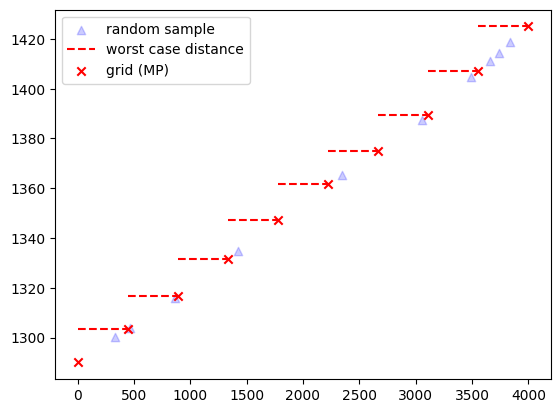

In [15]:
n_1D = 10  # number of samples


# sample for bounding
index = 1
# freeze the temperature

alt = np.linspace(MIN_alt, MAX_alt, n_1D)

# do linspace
curve_samples = [generate_dataset(1, MIN=[MIN_temp, alt_i], MAX=[MIN_temp, alt_i]) for alt_i in alt]
random_samples = generate_dataset(n_1D, MIN=[MIN_temp, MIN_alt], MAX=[MIN_temp, MAX_alt])
x_1D = np.array([sample[0][0, index] for sample in curve_samples])
y_1D = np.array([sample[1] for sample in curve_samples])
index_sort = np.argsort(x_1D)
x_1D = x_1D[index_sort]
y_1D = y_1D[index_sort]

X_rand_1D = random_samples[0][:, index]
Y_rand_1D = random_samples[1]

plt.scatter(X_rand_1D, Y_rand_1D, color="blue", marker="^", alpha=0.2)
for i in range(n_1D - 1):
    line_i = [x_1D[i], x_1D[i + 1]]
    plt.plot(line_i, [y_1D[i + 1]] * 2, "--", c="red")
    if i == 0:
        plt.scatter(x_1D, y_1D, color="red", marker="x")
        plt.legend(["random sample", "worst case distance", "grid (MP)"])

# plt.scatter(x_1D, y_1D, marker='x')

In [16]:
decomon_model = clone(model, method="crown")

In [17]:
def formal_shift_1D(shift=0, granularity=10, emp_sampling=20):
    # we normalize the shift
    K.set_value(model.layers[-1].bias, bias + shift)
    n_1D = granularity  # number of samples

    # sample for bounding
    index = 1
    # freeze the temperature
    alt = np.linspace(MIN_alt, MAX_alt, n_1D)

    # do linspace
    curve_samples = [generate_dataset(1, MIN=[MIN_temp, alt_i], MAX=[MIN_temp, alt_i]) for alt_i in alt]
    random_samples = generate_dataset(n_1D, MIN=[MIN_temp, MIN_alt], MAX=[MIN_temp, MAX_alt])

    x_1D = np.array([sample[0][0, index] for sample in curve_samples])
    X_rand_1D = random_samples[0][:, index]

    y_1D = np.array([sample[1] for sample in curve_samples])
    index_sort = np.argsort(x_1D)
    x_1D = x_1D[index_sort]
    y_1D = y_1D[index_sort]

    Y_rand_1D = random_samples[1]
    Y_pred_1D = model.predict((random_samples[0] - MEAN_x) / STD_x)[:, 0] * STD_y + MEAN_y

    z_1D = (np.array([sample[0][0, :] for sample in curve_samples]) - MEAN_x) / STD_x

    MIN_y = y_1D[0] - 5
    MAX_y = y_1D[-1] + 5

    plt.scatter(X_rand_1D, Y_rand_1D, color="blue", marker="^", alpha=0.2)
    plt.scatter(X_rand_1D, Y_rand_1D, color="purple", marker="v", alpha=0.7)
    count_unsafe = 0

    for i in range(n_1D - 1):
        line_i = [x_1D[i], x_1D[i + 1]]
        plt.plot(line_i, [y_1D[i + 1]] * 2, "--", c="red")

        x_min_i = z_1D[i][None]
        x_max_i = z_1D[i + 1][None]
        upper_i = get_lower_box(decomon_model, x_min=x_min_i, x_max=x_max_i)[0, 0] * STD_y + MEAN_y

        if upper_i > MAX_y:
            MAX_y = upper_i + 5
        if upper_i < MIN_y:
            MIN_y = upper_i - 5

        if upper_i >= y_1D[i + 1]:
            plt.plot(line_i, [upper_i] * 2, "-", c="green")
        else:
            count_unsafe += 1
            plt.plot(line_i, [upper_i] * 2, "-", c="orange")

        plt.scatter(x_1D, y_1D, marker="x", c="red")
        if i == 0:
            plt.legend(["GT sample", "prediction", "worst case GT distance", "formal lower prediction", "grid (MP)"])

    plt.ylim([MIN_y, MAX_y])

    if count_unsafe:
        plt.title("UNSAFE 😲 ?: potential underestimation with shift={:.2f}".format(shift))
    else:
        plt.title("SAFE 😊 !: no underestimation with shift={:.2f}".format(shift))
    K.set_value(model.layers[-1].bias, bias)

In [18]:
interact(
    formal_shift_1D,
    shift=widgets.FloatSlider(value=0, min=0, max=0.8, step=0.001, continuous_update=False),
    granularity=widgets.IntSlider(value=10, min=1, max=20, step=1, continuous_update=False),
    emp_sampling=widgets.IntSlider(value=10, min=10, max=100, step=1, continuous_update=False),
)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='shift', max=0.8, step=0.001…

<function __main__.formal_shift_1D(shift=0, granularity=10, emp_sampling=20)>

This proof can be easily extended to any dimension, at the cost of worst over-approximation cost (higher shift value).
We split the space in boxes for various range of pressure altitude and temperature and run our method on each box.
The color of the box will be <span style="color:orange">orange</span> if we cannot prove formally overestimation by the shifted neural network and <span style="color:green">green</span> otherwhise

In [19]:
def formal_shift_2D(shift, grid_alt=1, grid_temp=1):
    K.set_value(model.layers[-1].bias, bias + shift)
    n_1D_alt = grid_alt  # number of split along the 'altitude' dimension
    n_1D_temp = grid_temp  # number of split along the 'temperature' dimension
    # sample for bounding
    alt = np.linspace(MIN_alt, MAX_alt, n_1D_alt)
    temp = np.linspace(MIN_temp, MAX_temp, n_1D_temp)

    # Create figure and axes
    fig, ax = plt.subplots()

    ax.set_xticks(alt)
    ax.set_yticks(temp)
    count_unsafe = 0
    error_formal = []

    for i, alt_i in enumerate(alt[:-1]):
        for j, temp_j in enumerate(temp[:-1]):
            d_x_i = alt[i + 1] - alt[i]
            d_y_j = temp[j + 1] - temp[j]

            x_max_i = alt[i + 1]
            x_max_j = temp[j + 1]
            _, y_max_ij = generate_dataset(1, MIN=[x_max_i, x_max_j], MAX=[x_max_i, x_max_j])
            lower_ij = (
                get_lower_box(decomon_model, x_min=np.array([temp[j], alt[i]]), x_max=np.array([x_max_j, x_max_i]))[
                    0, 0
                ]
                * STD_y
                + MEAN_y
            )

            if lower_ij >= y_max_ij:
                color = "green"
            else:
                error_formal.append((lower_ij - y_max_ij))
                count_unsafe = 1
                color = "orange"
            rect = patches.Rectangle((alt_i, temp_j), d_x_i, d_y_j, color=color)
            ax.add_patch(rect)
    if count_unsafe:
        plt.title("UNSAFE 😲 ?: potential underestimation with shift={:.2f}".format(shift))
    else:
        plt.title("SAFE 😊 !: no underestimation with shift={:.2f}".format(shift))
    K.set_value(model.layers[-1].bias, bias)

    plt.xlim([MIN_alt, MAX_alt])
    plt.ylim(MIN_temp, MAX_temp)
    plt.grid()
    plt.ylabel("temperature")
    plt.xlabel("pressure altitude")
    plt.show()

In [20]:
interact(
    formal_shift_2D,
    shift=widgets.FloatSlider(value=0, min=0, max=10, step=0.001, continuous_update=False),
    grid_alt=widgets.IntSlider(value=10, min=1, max=20, step=1, continuous_update=False),
    grid_temp=widgets.IntSlider(value=10, min=1, max=20, step=1, continuous_update=False),
)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='shift', max=10.0, step=0.00…

<function __main__.formal_shift_2D(shift, grid_alt=1, grid_temp=1)>